In [1]:
from __future__ import print_function

import numpy as np
import scipy as sp
from numpy import cos, sin, log, exp, log10, absolute, pi, sqrt
from scipy.integrate import odeint
from scipy.integrate import quad
from numpy.polynomial import chebyshev as T
from numpy.polynomial import hermite_e as H
from spectral_tools import Decompose, ModalD, NodalD, Vandermonde
from edgedetect import ConfigurePlots, ChebEdgeIII, Enhance, LocateEdges, LocateEdgesDeriv, MinMod, PeaksInDeriv
from mollification import PiecewiseMollify
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

<h3>Define the initial Gaussian to evolve

In [2]:
N = 32
c2s, s2c = Vandermonde(N)
modalD = ModalD(c2s)
nodalD = NodalD(c2s, s2c)

x = np.linspace(-1.0, 1.0, 500)
x_j = np.hstack((-1.0, T.Chebyshev.basis(N).deriv().roots(), 1.0))

sigma = 0.5/3.
gauss = lambda x: exp(-(x**2)/(2*(sigma**2)))
gaussx = np.frompyfunc(gauss, 1, 1)(x)

a_n = Decompose(gauss, c2s)

In [5]:
u_0 = np.array(np.dot(s2c, a_n), dtype='float64')
u_0[0] = u_0[-1]

(-1.0, 1.0)

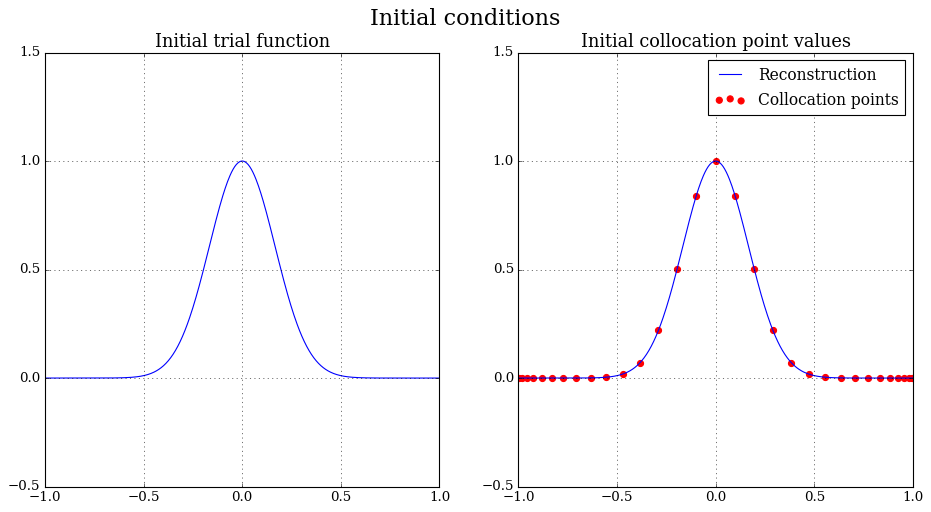

In [13]:
ConfigurePlots()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))
fig.suptitle('Initial conditions', fontsize=20)
ax1.set_title('Initial trial function', fontsize=16)
ax2.set_title('Initial collocation point values', fontsize=16)
ax1.plot(x, gaussx)
ax2.plot(x, gaussx, label='Reconstruction')
ax2.scatter(x_j, u_0, c='r', s=30, edgecolor='face', label='Collocation points')
ax2.legend(fontsize=14)
ax2.set_ylim(ax1.get_ylim())
ax2.set_xlim(ax1.get_xlim())

<h3> Define the Burgers derivative to use

In [217]:
def GetQkEps(N, s):
    
    theta = ((2.*s)-1.)/(2.*s)
    m_N = N**theta
    modal_Q = np.zeros(N+1)
    eps_N = N**(1.-(2.*s))
    
    for k in range(len(modal_Q)):
        
        if k >= m_N:
            modal_Q[k] = 1.-(m_N/k)**((2*s-1)/theta)
            
    nodal_Q = np.dot(s2c, modal_Q)
    
    return modal_Q, nodal_Q, eps_N

In [218]:
def BurgersNodalVisc(y, t0, nodalD, nodal_Q, eps_N):
    
    # using the structure of d_dt = A + B(C)
    
    N = modalD.shape[0] - 1
    w_N = pi/(2*N)
    
    #y[0] = y[-1]
    
    F_u = 0.5 * np.power(y, 2)
    A = - np.dot(nodalD, F_u)
    
    C = nodal_Q * np.dot(nodalD, y)
    B = - eps_N * np.dot(nodalD, C)
    B[-1] = B[-1] - eps_N/w_N * C[-1]
    B[0] = 0
    
    derivative = A + B
    #derivative[0] = 0
    
    return derivative

In [219]:
def BurgersModalVisc(y, t0, modalD, nodalD, modal_Q, eps_N):
    
    # using the structure of d_dt = -(A + B(C))
    
    N = modalD.shape[0] - 1
    w_N = pi/(2*N)
    
    #y[0] = y[-1]
    
    F_u = 0.5 * np.power(y, 2)
    A = - np.dot(nodalD, F_u)
    
    C = modal_Q * np.dot(c2s, np.dot(nodalD, y))
    B = - eps_N * np.dot(s2c, np.dot(modalD, C))
    B[-1] = B[-1] - eps_N/w_N * np.dot(s2c, C)[-1]
    B[0] = 0
    
    derivative = A + B
    #derivative[0] = 0
    
    return derivative

In [220]:
def BurgersInviscid(y, t0, nodalD):
    
    N = modalD.shape[0] - 1
    
    y[0] = y[-1]
    
    F_u = 0.5 * np.power(y, 2)
    derivative = - np.dot(nodalD, F_u)
    
    return derivative

In [221]:
def SimpleEuler(y0, t, s):
    
    N = y0.shape[0] - 1
    modal_Q, nodal_Q, eps_N = GetQkEps(N, s)
    
    dt = t[1] - t[0]
    
    inviscid = np.empty((len(t), len(y0)))
    modal = np.empty((len(t), len(y0)))
    nodal = np.empty((len(t), len(y0)))
    inviscid[0,:] = y0
    modal[0,:] = y0
    nodal[0,:] = y0
    
    for i in range(len(t)-1):

        inviscid_der = BurgersInviscid(inviscid[i,:], i, nodalD)
        modal_der = BurgersModalVisc(modal[i,:], i, modalD, nodalD, modal_Q, eps_N)
        nodal_der = BurgersNodalVisc(nodal[i,:], i, nodalD, nodal_Q, eps_N)
        
        inviscid[i+1,:] = inviscid[i,:] + dt * inviscid_der
        modal[i+1,:] = modal[i,:] + dt * modal_der
        nodal[i+1,:] = nodal[i,:] + dt * nodal_der
        
        inviscid[i+1,0] = inviscid[i+1,-1]
        modal[i+1,0] = modal[i+1,-1]
        nodal[i+1,0] = nodal[i+1,-1]
        
    return inviscid, modal, nodal

<h3> Evolve in time

In [222]:
t = np.linspace(0, 1.5, 4000)
s = 1
modal_Q, nodal_Q, eps_N = GetQkEps(N, s)

In [223]:
euler_inviscid, euler_modal, euler_nodal = SimpleEuler(u_0, t, s)

odeint_modal = odeint(BurgersModalVisc, u_0, t, args=(modalD, nodalD, modal_Q, eps_N))
odeint_nodal = odeint(BurgersNodalVisc, u_0, t, args=(nodalD, nodal_Q, eps_N))
odeint_inviscid = odeint(BurgersInviscid, u_0, t, args=(nodalD,))

/Users/asiamacbook/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in power
/Users/asiamacbook/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in power


In [224]:
odeint_nodalx = np.empty((len(t), len(x)))
odeint_modalx = np.empty((len(t), len(x)))
odeint_inviscidx = np.empty((len(t), len(x)))
euler_nodalx = np.empty((len(t), len(x)))
euler_modalx = np.empty((len(t), len(x)))
euler_inviscidx = np.empty((len(t), len(x)))


for idx, t_n in enumerate(t):
    a_nn = np.dot(c2s, odeint_nodal[idx,:])
    a_nm = np.dot(c2s, odeint_modal[idx,:])
    a_ni = np.dot(c2s, odeint_inviscid[idx,:])
    ea_nn = np.dot(c2s, euler_nodal[idx,:])
    ea_nm = np.dot(c2s, euler_modal[idx,:])
    ea_ni = np.dot(c2s, euler_inviscid[idx,:])
    
    odeint_nodalx[idx,:] = T.chebval(x, a_nn)
    odeint_modalx[idx,:] = T.chebval(x, a_nm)
    odeint_inviscidx[idx,:] = T.chebval(x, a_ni)
    euler_nodalx[idx,:] = T.chebval(x, ea_nn)
    euler_modalx[idx,:] = T.chebval(x, ea_nm)
    euler_inviscidx[idx,:] = T.chebval(x, ea_ni)

(<matplotlib.legend.Legend at 0x17dfadc90>,
 <matplotlib.legend.Legend at 0x17dfdd310>)

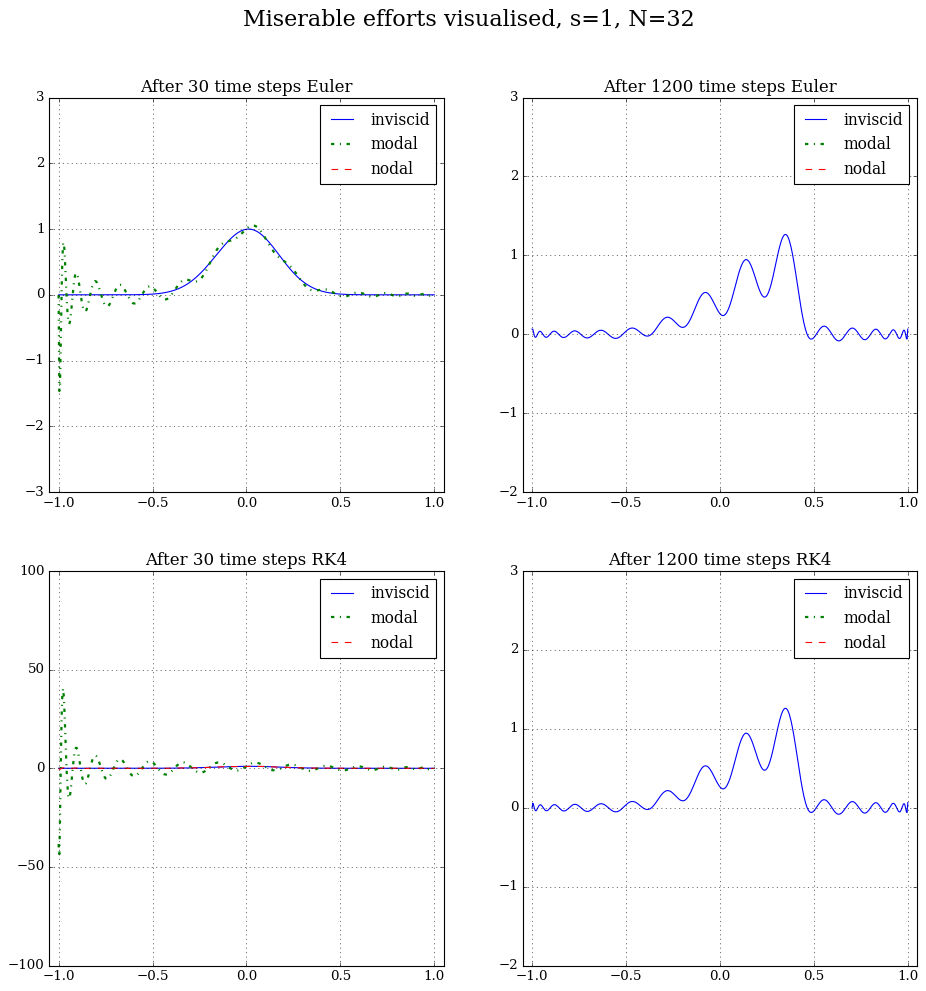

In [225]:
fig, ax = plt.subplots(2,2, figsize=(14,14))
fig.suptitle('Miserable efforts visualised, s=1, N=32', fontsize=20)
ax[0,0].set_title('After 30 time steps Euler'), ax[0,1].set_title('After 1200 time steps Euler')
ax[1,0].set_title('After 30 time steps RK4'), ax[1,1].set_title('After 1200 time steps RK4')
ax[0,1].set_ylim(-2,3), ax[1,1].set_ylim(-2,3)


ax[0,0].plot(x, euler_inviscidx[30,:], label='inviscid'), ax[0,0].plot(x, euler_modalx[30,:], '-.', lw=2, label='modal'), 
ax[0,0].plot(x, euler_nodalx[30,:], '--', label='nodal') 
ax[0,1].plot(x, euler_inviscidx[1200,:], label='inviscid'), ax[0,1].plot(x, euler_modalx[1200,:], '-.', lw=2, label='modal'), 
ax[0,1].plot(x, euler_nodalx[1200,:], '--',  label='nodal') 
ax[1,0].plot(x, odeint_inviscidx[30,:], label='inviscid'), ax[1,0].plot(x, odeint_modalx[30,:], '-.', lw=2, label='modal'), 
ax[1,0].plot(x, odeint_nodalx[30,:], '--', label='nodal') 
ax[1,1].plot(x, odeint_inviscidx[1200,:], label='inviscid'), ax[1,1].plot(x, odeint_modalx[1200,:], '-.', lw=2, label='modal'), 
ax[1,1].plot(x, odeint_nodalx[1200,:], '--', label='nodal') 
ax[0,0].set_xlim(-1.05, 1.05), ax[0,1].set_xlim(-1.05, 1.05), ax[1,0].set_xlim(-1.05, 1.05), ax[1,1].set_xlim(-1.05, 1.05)
ax[0,0].legend(fontsize=14), ax[0,1].legend(fontsize=14), ax[1,0].legend(fontsize=14), ax[1,1].legend(fontsize=14)

In [226]:
s2 = 2
modal_Q2, nodal_Q2, eps_N2 = GetQkEps(N, s2)

euler_inviscid2, euler_modal2, euler_nodal2 = SimpleEuler(u_0, t, s2)

odeint_modal2 = odeint(BurgersModalVisc, u_0, t, args=(modalD, nodalD, modal_Q2, eps_N2))
odeint_nodal2 = odeint(BurgersNodalVisc, u_0, t, args=(nodalD, nodal_Q2, eps_N2))
odeint_inviscid2 = odeint(BurgersInviscid, u_0, t, args=(nodalD,))

/Users/asiamacbook/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in power
/Users/asiamacbook/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in power


In [227]:
odeint_nodalx2 = np.empty((len(t), len(x)))
odeint_modalx2 = np.empty((len(t), len(x)))
odeint_inviscidx2 = np.empty((len(t), len(x)))
euler_nodalx2 = np.empty((len(t), len(x)))
euler_modalx2 = np.empty((len(t), len(x)))
euler_inviscidx2 = np.empty((len(t), len(x)))


for idx, t_n in enumerate(t):
    a_nn = np.dot(c2s, odeint_nodal2[idx,:])
    a_nm = np.dot(c2s, odeint_modal2[idx,:])
    a_ni = np.dot(c2s, odeint_inviscid2[idx,:])
    ea_nn = np.dot(c2s, euler_nodal2[idx,:])
    ea_nm = np.dot(c2s, euler_modal2[idx,:])
    ea_ni = np.dot(c2s, euler_inviscid2[idx,:])
    
    odeint_nodalx2[idx,:] = T.chebval(x, a_nn)
    odeint_modalx2[idx,:] = T.chebval(x, a_nm)
    odeint_inviscidx2[idx,:] = T.chebval(x, a_ni)
    euler_nodalx2[idx,:] = T.chebval(x, ea_nn)
    euler_modalx2[idx,:] = T.chebval(x, ea_nm)
    euler_inviscidx2[idx,:] = T.chebval(x, ea_ni)

(<matplotlib.legend.Legend at 0x1842c1dd0>,
 <matplotlib.legend.Legend at 0x18439bd90>)

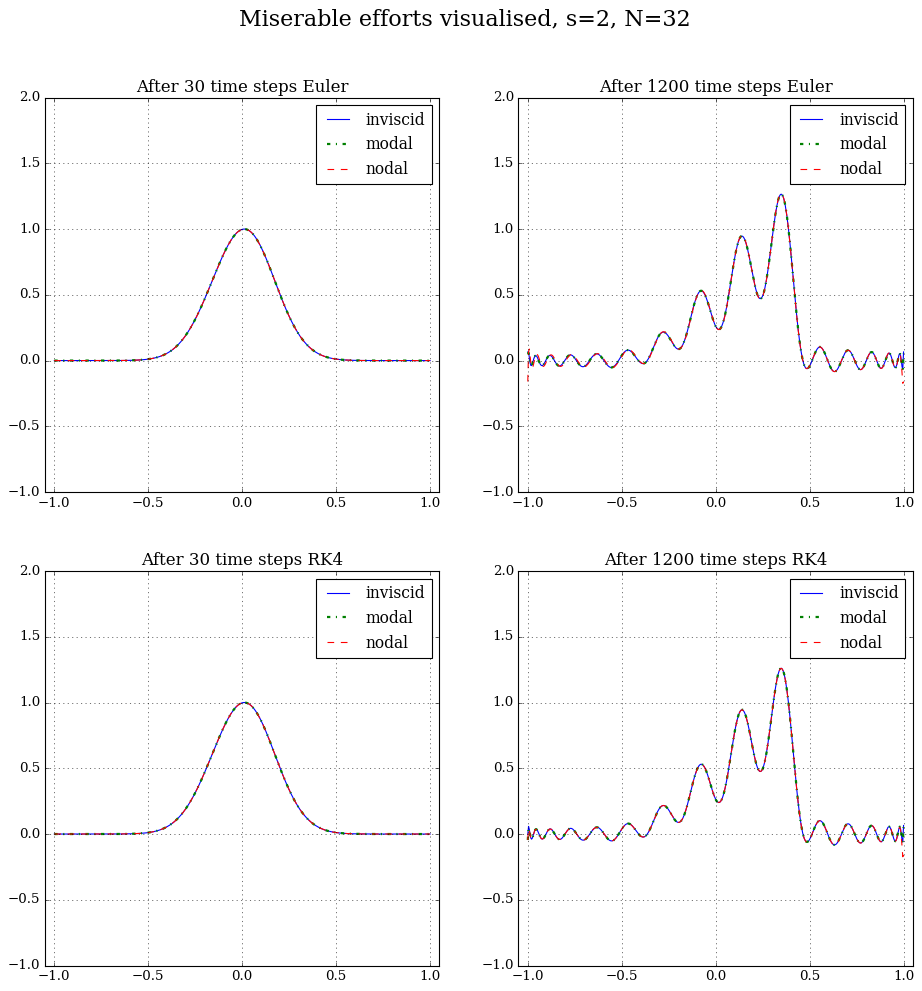

In [228]:
fig, ax = plt.subplots(2,2, figsize=(14,14))
fig.suptitle('Miserable efforts visualised, s=2, N=32', fontsize=20)
ax[0,0].set_title('After 30 time steps Euler'), ax[0,1].set_title('After 1200 time steps Euler')
ax[1,0].set_title('After 30 time steps RK4'), ax[1,1].set_title('After 1200 time steps RK4')

ax[0,0].plot(x, euler_inviscidx2[30,:], label='inviscid'), ax[0,0].plot(x, euler_modalx2[30,:], '-.', lw=2, label='modal'), 
ax[0,0].plot(x, euler_nodalx2[30,:], '--', label='nodal') 
ax[0,1].plot(x, euler_inviscidx2[1200,:], label='inviscid'), ax[0,1].plot(x, euler_modalx2[1200,:], '-.', lw=2, label='modal'), 
ax[0,1].plot(x, euler_nodalx2[1200,:], '--',  label='nodal') 
ax[1,0].plot(x, odeint_inviscidx2[30,:], label='inviscid'), ax[1,0].plot(x, odeint_modalx2[30,:], '-.', lw=2, label='modal'), 
ax[1,0].plot(x, odeint_nodalx2[30,:], '--', label='nodal') 
ax[1,1].plot(x, odeint_inviscidx2[1200,:], label='inviscid'), ax[1,1].plot(x, odeint_modalx2[1200,:], '-.', lw=2, label='modal'), 
ax[1,1].plot(x, odeint_nodalx2[1200,:], '--', label='nodal') 
ax[0,0].set_xlim(-1.05, 1.05), ax[0,1].set_xlim(-1.05, 1.05), ax[1,0].set_xlim(-1.05, 1.05), ax[1,1].set_xlim(-1.05, 1.05)
ax[0,0].legend(fontsize=14), ax[0,1].legend(fontsize=14), ax[1,0].legend(fontsize=14), ax[1,1].legend(fontsize=14)